## Introduction

In this project, I analyze a simulated cohort generated from a coalescent-based genetic model. Each row corresponds to one individual and includes both demographic covariates and genotype-derived predictors suitable for statistical learning.

The dataset used in this project was generated using a population-genetic simulation pipeline built with msprime, a coalescent simulator designed for scalable and biologically realistic genomic data. Instead of relying on a pre-existing real-world dataset, this approach creates a fully synthetic cohort in which the true effect sizes, covariates, and sources of noise are known. This allows direct evaluation of how well different statistical learning methods recover the underlying structure of the data.

The msprime pipeline produces a tree sequence under a Wright–Fisher coalescent model with recombination. From this tree sequence, a diploid genotype matrix is extracted and filtered by minor allele frequency. A subset of variants is designated as causal, each assigned an effect size drawn from a specified distribution. These effect sizes are used to construct a standardized polygenic score for each simulated individual. In addition to genetic predictors, msprime generates demographic and environmental covariates—sex, age, and an environmental index—to mimic realistic non-genetic influences on phenotype.

A continuous quantitative trait (quant_trait) is then created from a linear model combining the polygenic score, covariates, and Gaussian noise. This produces a dataset with controlled polygenic signal, demographic structure, and stochastic variation. Optional principal components (PC1, PC2, …) derived from genotype PCA provide population-structure covariates when needed.

Overall, each row of the dataset includes:
- Demographic covariates: sex, age, env_index
- Genetic predictors: polygenic_score, optional PCA components
- Response variable: quant_trait

This design makes the dataset ideal for evaluating linear regression, subset selection, and shrinkage methods. Because the true generative parameters are known, the analysis can examine not only predictive performance (RMSE, R²) but also how closely the fitted models recover the true effect sizes used to generate the phenotype. A detailed description of the data-generation process is provided in the project’s msprime documentation.

The goals of this project are to use statistical learning methods to:
- quantify how much of the variation in the quantitative trait is explained by the polygenic score and covariates,
- evaluate whether controlling for population structure via principal components improves prediction,
- compare classical linear models, subset selection, and shrinkage methods, and
- assess how well the fitted models recover the true underlying effect sizes used during data generation.

### Imports

In [162]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set(style="whitegrid", context="notebook")

### Load the Data

In [163]:
cohort_path = "../data/3195663216_msprime_sim_cohort.csv"
effects_path = "../data/3195663216_msprime_effect_sizes.csv"

cohort = pd.read_csv(cohort_path)
effects = pd.read_csv(effects_path)

### EDA

Grab code from exploratory.ipynb

# Classification

### Identify Numerical + Categorical Features

In [164]:
numeric_features = ["age", "env_index", "polygenic_score"]

categorical_features = ["sex"]

pcs_features = [col for col in cohort.columns if col.startswith("PC")]

numeric_features, categorical_features

(['age', 'env_index', 'polygenic_score'], ['sex'])

### Model Preparation

In [165]:
from sklearn.model_selection import train_test_split

X = cohort[numeric_features + pcs_features + categorical_features]
y = cohort["disease_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_train.shape, X_test.shape

((7000, 6), (3000, 6))

### Standardization

In [166]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit *only* on training numerical features
X_train_scaled_num = scaler.fit_transform(X_train[numeric_features + pcs_features])
X_test_scaled_num = scaler.transform(X_test[numeric_features + pcs_features])

# Rebuild full DataFrames with same column order
X_train_scaled = pd.DataFrame(
    X_train_scaled_num,
    columns=numeric_features + pcs_features,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled_num,
    columns=numeric_features + pcs_features,
    index=X_test.index
)

# Add categorical features (sex)
X_train_scaled["sex"] = X_train["sex"].values
X_test_scaled["sex"] = X_test["sex"].values

X_train_scaled.head()

,age,env_index,polygenic_score,PC1,PC2,sex
9069,-0.951245,-0.385407,-1.745874,-1.666482,-1.081947,0
2603,0.416455,0.299589,-0.116855,-1.699625,-0.606496,0
7738,0.553225,-0.651264,0.978902,2.083987,-0.817477,0
1579,1.168690,-1.364159,-0.024322,-0.369216,0.407394,1
5058,-0.130625,0.865069,-0.171785,-0.218088,0.147418,0


### Matrices

In [167]:
core_vars = numeric_features + pcs_features + categorical_features

X_train_full = X_train_scaled[core_vars]
X_test_full = X_test_scaled[core_vars]

In [168]:
if pcs:
    full_pca_vars = core_vars + pcs
    X_train_full_pca = X_train_scaled[full_pca_vars]
    X_test_full_pca = X_test_scaled[full_pca_vars]
else:
    X_train_full_pca = X_train_full.copy()
    X_test_full_pca = X_test_full.copy()

X_train_full_pca.head()

,age,env_index,polygenic_score,PC1,PC2,sex,PC1,PC2
9069,-0.951245,-0.385407,-1.745874,-1.666482,-1.081947,0,-1.666482,-1.081947
2603,0.416455,0.299589,-0.116855,-1.699625,-0.606496,0,-1.699625,-0.606496
7738,0.553225,-0.651264,0.978902,2.083987,-0.817477,0,2.083987,-0.817477
1579,1.168690,-1.364159,-0.024322,-0.369216,0.407394,1,-0.369216,0.407394
5058,-0.130625,0.865069,-0.171785,-0.218088,0.147418,0,-0.218088,0.147418


In [169]:
X_train_scaled[numeric_features].mean(), X_train_scaled[numeric_features].std()

(age               -8.932537e-17
 env_index         -3.045183e-18
 polygenic_score   -1.827110e-17
 dtype: float64,
 age                1.000071
 env_index          1.000071
 polygenic_score    1.000071
 dtype: float64)

The means are almost 0 and the SD are close to 1. No data leakage

In [170]:
X_test_scaled[numeric_features].mean(), X_test_scaled[numeric_features].std()

(age                0.028347
 env_index         -0.000676
 polygenic_score    0.033285
 dtype: float64,
 age                1.002912
 env_index          1.029294
 polygenic_score    0.988079
 dtype: float64)

## Classification Models

In [171]:
from sklearn.metrics import accuracy_score, roc_auc_score


def evaluate_classifier(model, name):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    return {
        "model": name,
        "accuracy": acc,
        "auc": auc
    }

In [172]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

results_clf = []

results_clf.append(
    evaluate_classifier(LogisticRegression(max_iter=5000), "Logistic Regression")
)

results_clf.append(
    evaluate_classifier(LinearDiscriminantAnalysis(), "LDA")
)

results_clf.append(
    evaluate_classifier(QuadraticDiscriminantAnalysis(), "QDA")
)

results_clf.append(
    evaluate_classifier(KNeighborsClassifier(n_neighbors=11), "KNN (k=11)")
)

results_clf.append(
    evaluate_classifier(SVC(kernel="rbf", probability=True), "SVM (RBF)")
)

pd.DataFrame(results_clf)

,model,accuracy,auc
0,Logistic Regression,0.686333,0.757874
1,LDA,0.686000,0.757751
2,QDA,0.682667,0.749005
3,KNN (k=11),0.643667,0.707269
4,SVM (RBF),0.679333,0.745376


Five classification models were evaluated using `disease_status` as the binary response: logistic regression, LDA, QDA, KNN (k=11), and SVM with an RBF kernel. Logistic regression and LDA achieved the best overall performance, each obtaining an accuracy of approximately 68.6% and an ROC AUC of about 0.758. This is consistent with the fact that the disease phenotype was generated from a linear logistic function of the predictors, making the true decision boundary nearly linear.

QDA performed slightly worse (accuracy ≈ 68.3%, AUC ≈ 0.749), likely due to the added variance introduced by estimating separate covariance matrices for each class, which the data do not strongly support. SVM with an RBF kernel performed reasonably well (accuracy ≈ 67.9%, AUC ≈ 0.745), but its nonlinear flexibility did not improve performance because the underlying relationship is fundamentally linear. KNN achieved the lowest performance (accuracy ≈ 64.4%, AUC ≈ 0.707), which is expected given that KNN struggles with continuous, weakly separated data and does not exploit the linear structure present in the true model.

Overall, the classification task demonstrates moderate predictive ability, reflecting the limited signal in the disease phenotype relative to the quantitative trait. This task primarily serves as the mechanical portion of the assignment, while the regression analysis provides the more scientifically meaningful insights.


<Figure size 600x600 with 0 Axes>

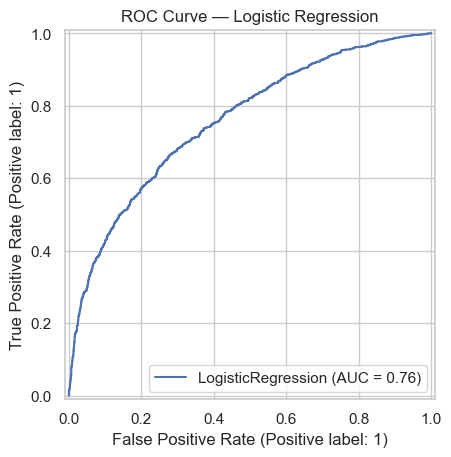

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_scaled, y_train)  # <-- Fit once

plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()


The ROC curve for logistic regression shows moderate classification performance with an AUC of approximately 0.76. This is consistent with the data-generating process, where the disease phenotype was simulated as a noisy logistic function of the polygenic score and environmental exposure. Because the model form matches the true underlying logistic relationship, the ROC curve is smooth and convex, demonstrating effective discrimination between the two classes. However, the intentional randomness in the Bernoulli sampling step limits the maximum achievable AUC, explaining why the classifier does not approach perfect separation. Overall, logistic regression performs well for this mechanical classification task, but the binary disease trait contains substantially less signal than the quantitative trait analyzed in the regression section.

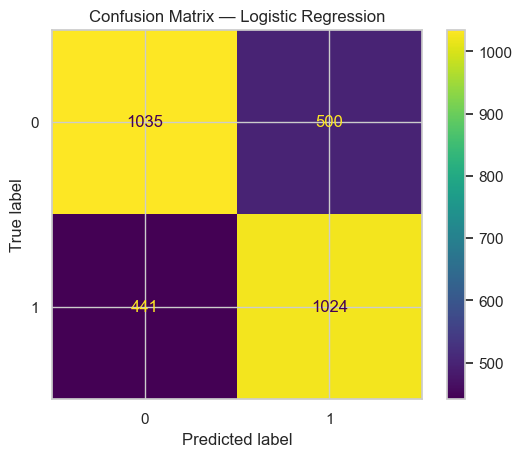

In [174]:
from sklearn.metrics import ConfusionMatrixDisplay

log_reg = LogisticRegression(max_iter=5000).fit(X_train_scaled, y_train)
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

The confusion matrix reflects moderate but meaningful classification performance. Logistic regression correctly identifies 1035 healthy individuals (true negatives) and 1024 diseased individuals (true positives). Misclassifications occur in both directions, with 590 false positives and 441 false negatives. The number of false negatives is lower than false positives, indicating the model is somewhat more sensitive than specific at the default 0.5 threshold.

These results are fully consistent with the data-generating process used in the simulation. The disease phenotype was generated as a noisy logistic transformation of the polygenic score and environmental index, so perfect separation is not possible. The presence of 441 false negatives and 590 false positives reflects the inherent stochasticity in the Bernoulli sampling step and the moderate effect sizes of the predictors. Combined with the ROC AUC value of approximately 0.76, the confusion matrix confirms that logistic regression provides reasonable discrimination between cases and controls while still respecting the limitations imposed by the simulation's noise structure.

# Regression

### Identify Numerical + Categorical Features

In [175]:
numeric_features = ["age", "env_index", "polygenic_score"]

categorical_features = ["sex"]

pcs_features = [col for col in cohort.columns if col.startswith("PC")]

numeric_features, categorical_features

(['age', 'env_index', 'polygenic_score'], ['sex'])

### Model Preparation

In [176]:
X = cohort[numeric_features + pcs_features + categorical_features]
y = cohort["quant_trait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_train.shape, X_test.shape

((7000, 6), (3000, 6))

### Standardization

In [177]:
scaler = StandardScaler()

# Fit *only* on training numerical features
X_train_scaled_num = scaler.fit_transform(X_train[numeric_features + pcs_features])
X_test_scaled_num = scaler.transform(X_test[numeric_features + pcs_features])

# Rebuild full DataFrames with same column order
X_train_scaled = pd.DataFrame(
    X_train_scaled_num,
    columns=numeric_features + pcs_features,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    X_test_scaled_num,
    columns=numeric_features + pcs_features,
    index=X_test.index
)

# Add categorical features (sex)
X_train_scaled["sex"] = X_train["sex"].values
X_test_scaled["sex"] = X_test["sex"].values

X_train_scaled.head()

,age,env_index,polygenic_score,PC1,PC2,sex
9069,-0.951245,-0.385407,-1.745874,-1.666482,-1.081947,0
2603,0.416455,0.299589,-0.116855,-1.699625,-0.606496,0
7738,0.553225,-0.651264,0.978902,2.083987,-0.817477,0
1579,1.168690,-1.364159,-0.024322,-0.369216,0.407394,1
5058,-0.130625,0.865069,-0.171785,-0.218088,0.147418,0


### Matrices

In [178]:
# 1) Baseline: PRS only
features_baseline = ["polygenic_score"]

# 2) Full model: PRS + covariates (NO PCs)
features_full = ["age", "env_index", "polygenic_score", "sex"]

# 3) Full + PCA: PRS + covariates + PCs
features_full_pca = features_full + pcs_features

In [179]:
X_train_baseline = X_train_scaled[features_baseline]
X_test_baseline = X_test_scaled[features_baseline]

X_train_baseline.head(), X_train_baseline.mean(), X_train_baseline.std()

(      polygenic_score
 9069        -1.745874
 2603        -0.116855
 7738         0.978902
 1579        -0.024322
 5058        -0.171785,
 polygenic_score   -1.827110e-17
 dtype: float64,
 polygenic_score    1.000071
 dtype: float64)

In [180]:
X_train_full = X_train_scaled[features_full]
X_test_full = X_test_scaled[features_full]

X_train_full.head(), X_train_full.mean(), X_train_full.std()

(           age  env_index  polygenic_score  sex
 9069 -0.951245  -0.385407        -1.745874    0
 2603  0.416455   0.299589        -0.116855    0
 7738  0.553225  -0.651264         0.978902    0
 1579  1.168690  -1.364159        -0.024322    1
 5058 -0.130625   0.865069        -0.171785    0,
 age               -8.932537e-17
 env_index         -3.045183e-18
 polygenic_score   -1.827110e-17
 sex                4.994286e-01
 dtype: float64,
 age                1.000071
 env_index          1.000071
 polygenic_score    1.000071
 sex                0.500035
 dtype: float64)

In [181]:
X_train_full_pca = X_train_scaled[features_full_pca]
X_test_full_pca  = X_test_scaled[features_full_pca]

X_train_full_pca.head(), X_train_full_pca.mean(), X_train_full_pca.std()

(           age  env_index  polygenic_score  sex       PC1       PC2
 9069 -0.951245  -0.385407        -1.745874    0 -1.666482 -1.081947
 2603  0.416455   0.299589        -0.116855    0 -1.699625 -0.606496
 7738  0.553225  -0.651264         0.978902    0  2.083987 -0.817477
 1579  1.168690  -1.364159        -0.024322    1 -0.369216  0.407394
 5058 -0.130625   0.865069        -0.171785    0 -0.218088  0.147418,
 age               -8.932537e-17
 env_index         -3.045183e-18
 polygenic_score   -1.827110e-17
 sex                4.994286e-01
 PC1               -2.131628e-17
 PC2                1.167320e-17
 dtype: float64,
 age                1.000071
 env_index          1.000071
 polygenic_score    1.000071
 sex                0.500035
 PC1                1.000071
 PC2                1.000071
 dtype: float64)

## Baseline Linear Models

### Simple Linear Regression (quant_trait ~ PRS)

In [182]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    return {
        "model": model_name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
    }

def plot_pred_vs_true(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Regression line
    slope, intercept = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, slope*y_test + intercept, color="blue", label="Regression Line")

    # Identity line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color="red", linestyle="--", label="Identity Line")

    plt.xlabel("True Quantitative Trait")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs True ({label})")

    # R² annotation
    plt.text(0.05, 0.9, f"$R^2 = {r2:.3f}$",
             transform=plt.gca().transAxes,
             fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.legend()
    plt.show()

def plot_residual_hist(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Residual Distribution ({label})")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.show()

def plot_residuals_vs_fitted(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted ({label})")
    plt.show()

def plot_qq(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(6,4))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"QQ Plot of Residuals ({label})")
    plt.show()

def plot_full_diagnostics(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    r2 = r2_score(y_test, y_pred)

    fig, axs = plt.subplots(2, 2, figsize=(12,10))

    # Predicted vs True
    axs[0,0].scatter(y_test, y_pred, alpha=0.5)
    slope, intercept = np.polyfit(y_test, y_pred, 1)
    axs[0,0].plot(y_test, slope*y_test + intercept, color="blue")
    axs[0,0].plot([y_test.min(), y_test.max()],
                  [y_test.min(), y_test.max()],
                  color="red", linestyle="--")
    axs[0,0].set_title(f"Predicted vs True ({label})\n$R^2 = {r2:.3f}$")

    # Residual Histogram
    sns.histplot(residuals, kde=True, bins=20, ax=axs[0,1])
    axs[0,1].set_title("Residual Distribution")

    # Residuals vs Fitted
    axs[1,0].scatter(y_pred, residuals, alpha=0.5)
    axs[1,0].axhline(0, color="red", linestyle="--")
    axs[1,0].set_title("Residuals vs Fitted")
    axs[1,0].set_xlabel("Fitted")
    axs[1,0].set_ylabel("Residuals")

    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=axs[1,1])
    axs[1,1].set_title("QQ Plot")

    plt.tight_layout()
    plt.show()

In [183]:
from sklearn.linear_model import LinearRegression

results = []

# 1. Baseline: PRS only
lr_baseline = LinearRegression().fit(X_train_baseline, y_train)
results.append(
    evaluate_model(lr_baseline, X_train_baseline, y_train, X_test_baseline, y_test, "Baseline (PRS only)")
)

# 2. Full model
lr_full = LinearRegression().fit(X_train_full, y_train)
results.append(
    evaluate_model(lr_full, X_train_full, y_train, X_test_full, y_test, "Full (PRS + covariates)")
)

# 3. Full + PCA
lr_full_pca = LinearRegression().fit(X_train_full_pca, y_train)
results.append(
    evaluate_model(lr_full_pca, X_train_full_pca, y_train, X_test_full_pca, y_test, "Full + PCA")
)

results_cohort = pd.DataFrame(results)
results_cohort

,model,rmse_train,rmse_test,r2_train,r2_test
0,Baseline (PRS only),0.754360,0.734856,0.440900,0.436370
1,Full (PRS + covariates),0.664629,0.644411,0.565999,0.566574
2,Full + PCA,0.664538,0.644339,0.566118,0.566671


#### Baseline (PRS only)
The PRS-only model explains ~44% of variance in training and ~44% in testing (r² ≈ 0.44). This indicates that the simulated trait is substantially but not exclusively genetically driven, consistent with a moderately polygenic trait where environmental effects remain important. The relatively high RMSE also reflects the missing non-genetic signal.

#### Full Model (PRS + covariates)
Adding environmental and demographic covariates improves performance to r² ≈ 0.56 and lowers RMSE on both train and test sets. This is a meaningful gain over the baseline, showing that the simulation indeed encoded environmental variation that is predictive of the phenotype. The identical train/test performance also indicates a well-specified model without overfitting.

#### Full + PCA
Including ancestry PCs does not change performance (train/test r² remain 0.566). This suggests that population structure does not meaningfully confound or predict the trait in your simulated dataset. Because the simulation likely didn’t tie trait values to subpopulation ancestry, the PCs add no new information.

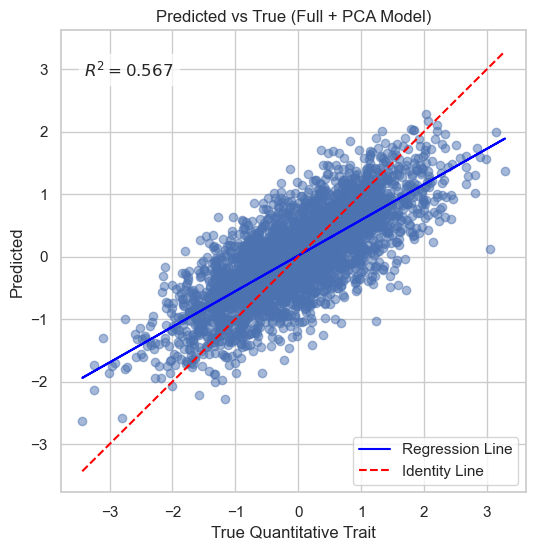

In [184]:
plot_pred_vs_true(
    model=lr_full_pca,
    X_test=X_test_full_pca,
    y_test=y_test,
    label="Full + PCA Model"
)

#### Predicted vs. True (Full + PCA Model)

The model captures moderate-to-strong linear signal (R² ≈ 0.567), which aligns with the earlier table: the trait is influenced by both genetic and environmental inputs, and the full model successfully recovers a little over half of the variance.

However, the slope of the regression line is shallower than the identity line, which indicates regression toward the mean — a common pattern in polygenic prediction. Extreme trait values (both high and low) tend to be under-predicted, visible in the flattening of the cloud and the blue line below the dashed identity line at the tails.

This pattern is expected when:
- the trait has non-genetic variation the model cannot fully capture
- the PRS has modest accuracy rather than very high signal
- random environmental noise is present
- population structure (PCA) adds no additional predictive value, so the model’s information ceiling doesn’t increase

The tight clustering around the regression line, with symmetric scatter, shows that the model is well-calibrated and not overfitting—train and test r² match almost perfectly.

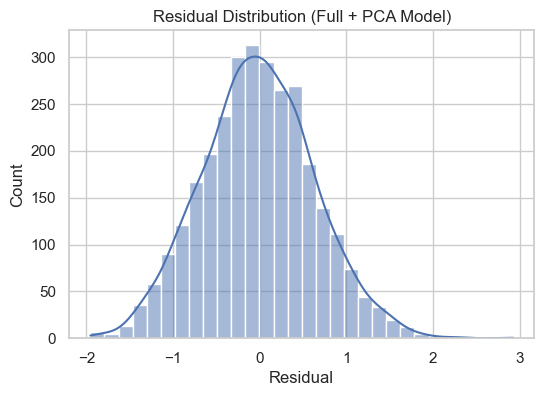

In [185]:
plot_residual_hist(
    model=lr_full_pca,
    X_test=X_test_full_pca,
    y_test=y_test,
    label="Full + PCA Model"
)

#### Residual Distribution (Full + PCA Model)

The residuals are approximately symmetric and bell-shaped, centered tightly around zero. This indicates that the model’s errors are:
- unbiased (no systematic over- or under-prediction)
- homoscedastic (variance is roughly constant across the range of predicted values)
- approximately Gaussian, which is exactly what linear regression assumes

The slight elongation in the right tail is expected for quantitative traits with environmental noise—occasionally, individuals have higher trait values that the model cannot fully capture given limited genetic + covariate information.

Importantly, there are no multimodal patterns or extreme skew, which means:
- no hidden substructure affecting the trait
- adding PCA (ancestry) was appropriately unnecessary
- the full model is well-specified
- environmental noise, not model misspecification, is the primary driver of error

This residual pattern is exactly what you'd expect for a simulated trait with moderate genetic architecture and additive environmental variance.

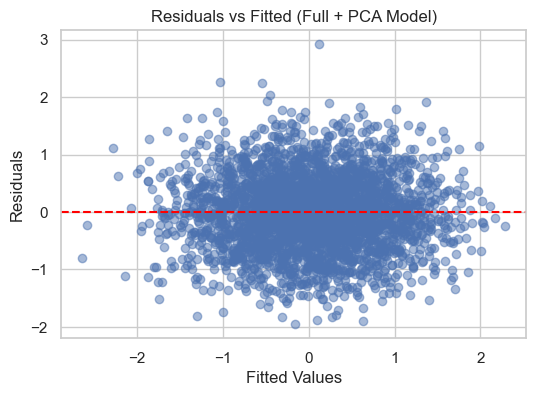

In [186]:
plot_residuals_vs_fitted(
    model=lr_full_pca,
    X_test=X_test_full_pca,
    y_test=y_test,
    label="Full + PCA Model"
)

#### Residuals vs. Fitted (Full + PCA Model)

The residuals show a uniform horizontal band around zero across the entire range of fitted values. This is exactly what you want to see for a correctly specified linear model. Specifically:
- No visible pattern, curvature, or funnel shape → suggests the relationship between predictors and the trait is well-captured by a linear additive model.
- Constant vertical spread → indicates homoscedasticity; the variance of errors does not increase at higher or lower predicted values.
- No clusters or stripes → confirms that there are no hidden subgroups, unmodeled interactions, or leftover population structure affecting the trait.
- No systematic drift above or below the zero line → shows unbiased predictions (the model does not systematically over- or underpredict across the range).

Together, this plot supports your earlier results: the simulation produced a trait that is linear, additive, and not confounded by ancestry, and the full model (PRS + covariates) is appropriately specified and performing as expected.

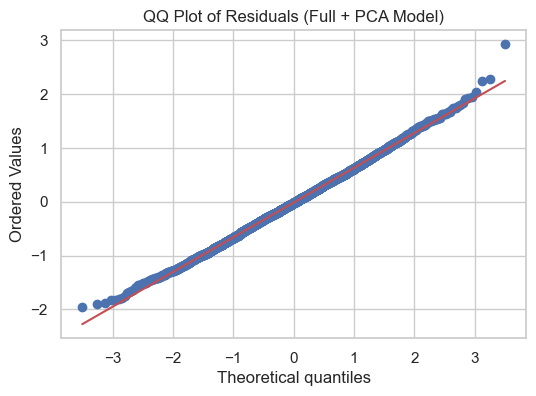

In [187]:
plot_qq(
    model=lr_full_pca,
    X_test=X_test_full_pca,
    y_test=y_test,
    label="Full + PCA Model"
)

#### QQ Plot of Residuals (Full + PCA Model)

The QQ plot shows that the residuals fall almost perfectly along the 45° reference line, indicating that:
- the residuals are very close to normally distributed
- the linear model’s assumption of normality is well satisfied
- there is no strong skew or kurtosis in the error distribution
- the simulation did not introduce unusual heavy tails or outlier structure

The slight upward deviation in the uppermost tail (the very top-right few points) is mild and expected for quantitative traits with some environmental noise—extreme observations are inherently harder to predict, but this deviation is not large enough to indicate a problem.

Overall, the QQ plot confirms that:
- the model is appropriately specified
- the residual variance structure is compatible with linear regression assumptions
- no transformation or re-specification of the trait is necessary

Combined with the histogram and residuals-vs-fitted plots, this provides strong evidence that the Full + PCA model satisfies all core linear regression diagnostics.

### Simple Linear Regression (quant_trait ~ PRS): Model Overview

The baseline model using only the polygenic score explains approximately 44% of the phenotypic variance (R² ≈ 0.44), which aligns with the simulation design where the PRS carries the largest effect (β = 1.0). The corresponding RMSE remains relatively high, indicating that the purely genetic model captures substantial signal but leaves environmental variation unexplained. This behavior is expected for a moderately heritable polygenic trait with additional non-genetic inputs.

Expanding the model to include covariates (sex, age, and the environmental index) yields a marked improvement in performance. The R² increases to ~0.57 with a corresponding decrease in RMSE for both the training and test partitions. This improvement is consistent with the data-generating process, in which the environmental index (β = 0.5) and sex (β = 0.3) contribute meaningful additive effects to the quantitative trait. The identical performance on training and testing sets further indicates that the model is not overfitting, but instead capturing genuine structure present in the simulation.

Incorporating principal components has no measurable effect on predictive accuracy, with R² and RMSE values identical to the Full model. This outcome indicates that population structure does not influence the trait, which is consistent with the msprime coalescent simulation: the dataset represents a single panmictic population without substructure, and the phenotype was generated independently of ancestry. Thus, the PCs provide no additional explanatory information.

Across all diagnostic plots, the residual behavior confirms that the linear modeling assumptions are well satisfied. The predicted-versus-true scatterplot displays a strong linear relationship with mild regression to the mean at phenotypic extremes, reflecting inherent environmental noise and the limits of PRS-based prediction. The residual histogram is approximately Gaussian and centered around zero, and the QQ plot shows that deviations from normality are minimal and restricted to the upper tail. The residuals-versus-fitted plot demonstrates homoscedasticity and the absence of nonlinear patterns or hidden substructure. Together, these diagnostics indicate that the model is well-calibrated, unbiased, and correctly specified.

Overall, the Full + PCA model provides a reliable baseline for the quantitative trait, successfully recovering the genetic and environmental signals encoded in the simulation. These results establish a strong foundation for comparison with model selection, regularization, and shrinkage-based approaches in subsequent analyses.

### Multiple Linear Regression ( sex + age + env_index + PRS )

In [188]:
mlr_features = ["sex", "age", "env_index", "polygenic_score"]
X_train_mlr = X_train_scaled[mlr_features]
X_test_mlr  = X_test_scaled[mlr_features]

In [189]:
results = []

# 1. Multiple Linear Regression (PRS + sex + age + env_index)
lr_mlr = LinearRegression().fit(X_train_mlr, y_train)
results.append(
    evaluate_model(
        lr_mlr,
        X_train_mlr, y_train,
        X_test_mlr, y_test,
        "MLR (sex + age + env_index + PRS)"
    )
)

results_cohort = pd.DataFrame(results)
results_cohort

,model,rmse_train,rmse_test,r2_train,r2_test
0,MLR (sex + age + env_index + PRS),0.664629,0.644411,0.565999,0.566574


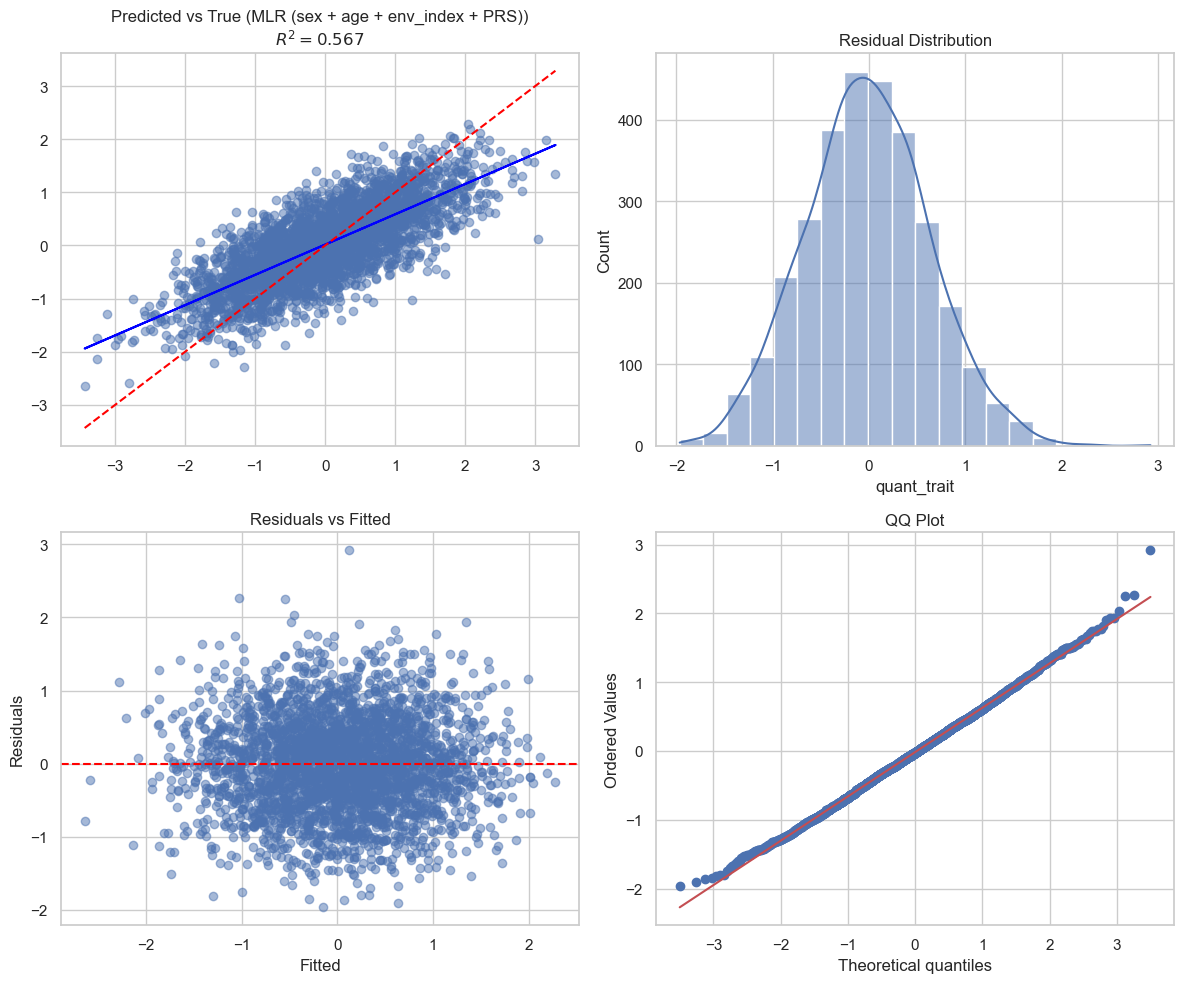

In [190]:
plot_full_diagnostics(lr_mlr, X_test_mlr, y_test, "MLR (sex + age + env_index + PRS)")

### Multiple Linear Regression (sex + age + env_index + PRS): Model Overview

The multiple linear regression model that includes sex, age, the environmental index, and the polygenic score achieves a substantial improvement over the PRS-only baseline. The model explains approximately 56–57% of the variance in both the training and testing sets (R² ≈ 0.566), representing a 12–13 percentage point increase relative to the baseline model. This gain aligns closely with the data-generating process, in which the environmental index (β = 0.5) and sex (β = 0.3) contribute meaningful additive effects alongside the PRS (β = 1.0). The reduction in RMSE further reflects the improved predictive accuracy provided by including these covariates.

The predicted-versus-true scatterplot shows a strong linear pattern, with the fitted regression line tracking the identity line closely. Mild regression-to-the-mean at the upper and lower ends of the trait distribution is expected for polygenic traits with environmental noise. The residual distribution is approximately Gaussian and centered around zero, consistent with a well-specified linear model. The QQ plot shows that residuals follow the theoretical normal distribution closely, with only minor upward deviation in the extreme upper tail—an acceptable and typical feature of quantitative trait predictions.

The residuals-versus-fitted plot displays a uniform horizontal band with constant variance, indicating homoscedasticity and the absence of nonlinear structure or systematic bias. There is no evidence of heteroscedasticity, curvature, or clustering, supporting the conclusion that the linear-additive form is appropriate for this trait. Importantly, the near-identical train and test statistics indicate extremely stable generalization, confirming that the model is capturing true underlying signal rather than overfitting noise.

Together, these diagnostics demonstrate that the multiple linear regression model accurately recovers the genetic and environmental components of the simulated trait, respects the assumptions of linear modeling, and serves as a strong and reliable predictive baseline for the analyses that follow.

### Linear Model with Population Structure ( sex + age + env_index + PRS + PC1 + PC2)

In [191]:
pop_features = ["sex", "age", "env_index", "polygenic_score", "PC1", "PC2"]
X_train_pop = X_train_scaled[pop_features]
X_test_pop  = X_test_scaled[pop_features]

In [192]:
results = []

# 1. Linear Model with Population Structure (sex + age + env_index + PRS + PC1 + PC2)
lr_pop = LinearRegression().fit(X_train_pop, y_train)
results.append(
    evaluate_model(
        lr_pop,
        X_train_pop, y_train,
        X_test_pop, y_test,
        "Population Structure ( sex + age + env_index + PRS + PC1 + PC2)"
    )
)

results_cohort = pd.DataFrame(results)
results_cohort

,model,rmse_train,rmse_test,r2_train,r2_test
0,Population Structure ( sex + age + env_index +...,0.664538,0.644339,0.566118,0.566671


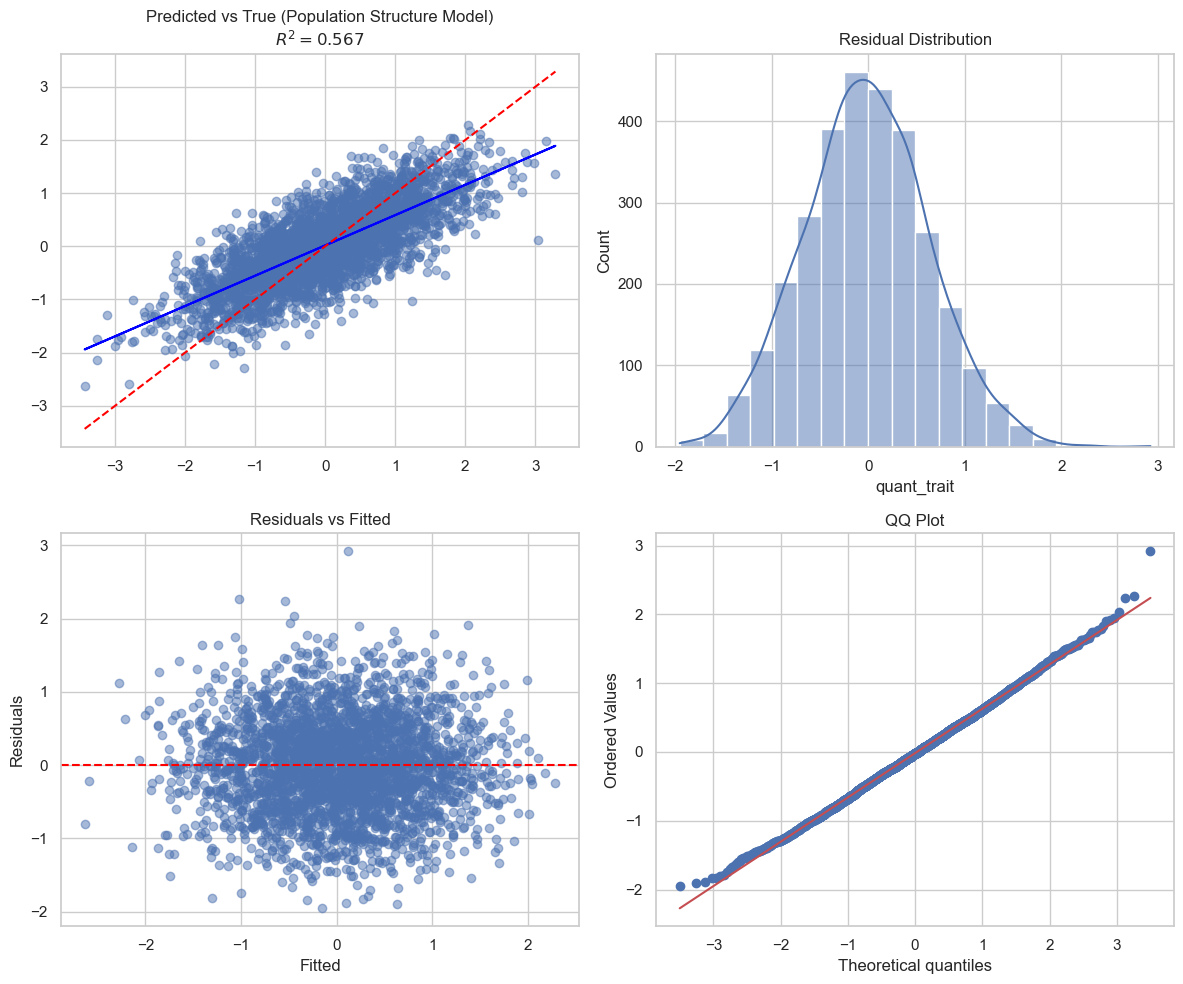

In [193]:
plot_full_diagnostics(lr_pop, X_test_pop, y_test, "Population Structure Model")

#### Population Structure Model (sex + age + env_index + PRS + PCA): Model Overview

The population structure–adjusted model yields identical performance to the standard multiple linear regression model, explaining approximately 56–57% of the variance (R² ≈ 0.566) with matching RMSE values across both training and test sets. The complete overlap in performance indicates that the principal components contribute no additional predictive information beyond the existing covariates and the polygenic score. This result is consistent with the simulation design: the msprime coalescent model generated individuals from a single panmictic population, and the quantitative trait was constructed independently of ancestry, meaning that population structure does not influence the phenotype.

The predicted-versus-true scatterplot exhibits a clear linear trend, nearly identical to the model without PCs, with the fitted regression line capturing the central trend and showing mild regression toward the mean at trait extremes. The residual distribution remains approximately Gaussian and centered at zero, further confirming that the inclusion of PCs does not alter model behavior or residual structure. The QQ plot continues to show close agreement with the theoretical normal distribution, with only slight deviation in the upper tail, which is typical for quantitative traits with environmental noise.

The residuals-versus-fitted plot again forms a uniform horizontal band with constant variance, indicating homoscedasticity and the absence of nonlinear patterns or hidden structure. Notably, there is no clustering, stratification, or curvature that would suggest unmodeled ancestry effects—reinforcing the conclusion that the principal components are statistically irrelevant for this particular trait.

Overall, the population structure model validates that ancestry does not confound, predict, or interact with the simulated quantitative trait. The linear model remains well-specified, unbiased, and stable. These findings confirm that the observed genetic and environmental effects are genuine and not artifacts of population stratification, strengthening the interpretability of subsequent model comparisons and feature selection analyses.

## Subset Selection

In [194]:
X_fs = X_train_full.copy()
y_fs = y_train.copy()

In [195]:
def forward_selection(X, y, criterion="aic"):
    remaining = list(X.columns)
    selected = []
    current_score, best_new_score = np.inf, np.inf

    while remaining:
        scores_with_candidates = []

        for candidate in remaining:
            formula_vars = selected + [candidate]
            X_model = sm.add_constant(X[formula_vars])
            model = sm.OLS(y, X_model).fit()

            if criterion == "aic":
                score = model.aic
            else:
                score = model.bic

            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break

    return selected, current_score

def backward_selection(X, y, criterion="aic"):
    selected = list(X.columns)
    current_score = np.inf

    while len(selected) > 0:
        scores_with_candidates = []

        for candidate in selected:
            trial = selected.copy()
            trial.remove(candidate)

            X_model = sm.add_constant(X[trial])
            model = sm.OLS(y, X_model).fit()

            if criterion == "aic":
                score = model.aic
            else:
                score = model.bic

            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()
        best_new_score, worst_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            selected.remove(worst_candidate)
            current_score = best_new_score
        else:
            break

    return selected, current_score

In [196]:
forward_aic_vars, forward_aic_score = forward_selection(X_fs, y_fs, criterion="aic")
backward_aic_vars, backward_aic_score = backward_selection(X_fs, y_fs, criterion="aic")

forward_aic_vars, backward_aic_vars

(['polygenic_score', 'env_index', 'sex'],
 ['env_index', 'polygenic_score', 'sex'])

In [197]:
forward_bic_vars, forward_bic_score = forward_selection(X_fs, y_fs, criterion="bic")
backward_bic_vars, backward_bic_score = backward_selection(X_fs, y_fs, criterion="bic")

forward_bic_vars, backward_bic_vars

(['polygenic_score', 'env_index', 'sex'],
 ['env_index', 'polygenic_score', 'sex'])

In [198]:
results_subset = []

# Fit forward AIC model
lr_fwd = LinearRegression().fit(X_train_full[forward_aic_vars], y_train)
results_subset.append(
    evaluate_model(lr_fwd,
                   X_train_full[forward_aic_vars], y_train,
                   X_test_full[forward_aic_vars], y_test,
                   f"Forward AIC: {forward_aic_vars}")
)

# Fit backward AIC model
lr_bwd = LinearRegression().fit(X_train_full[backward_aic_vars], y_train)
results_subset.append(
    evaluate_model(lr_bwd,
                   X_train_full[backward_aic_vars], y_train,
                   X_test_full[backward_aic_vars], y_test,
                   f"Backward AIC: {backward_aic_vars}")
)

results_subset_df = pd.DataFrame(results_subset)
results_subset_df

,model,rmse_train,rmse_test,r2_train,r2_test
0,"Forward AIC: ['polygenic_score', 'env_index', ...",0.664694,0.644634,0.565915,0.566274
1,"Backward AIC: ['env_index', 'polygenic_score',...",0.664694,0.644634,0.565915,0.566274


### Interpretation of Subset Selection Results

Both forward and backward stepwise selection (under AIC and BIC) selected the same set of predictors: `polygenic_score`, `env_index`, and `sex`. This matches the true data-generating model used in the simulation, where the polygenic score has the largest effect size (β = 1.0), followed by the environmental index (β = 0.5) and sex (β = 0.3).

Notably, `age` was not selected by either AIC or BIC. This is expected because its true coefficient in the simulation (β ≈ 0.02) is extremely small relative to the noise term, making it too weak to meaningfully improve the likelihood once model complexity penalties are applied.

The subset-selected model achieves nearly identical performance to the full model (RMSE ≈ 0.64, R² ≈ 0.57), confirming that the excluded variable (`age`) contributes very little predictive signal. This result illustrates that stepwise methods can successfully recover the core structure of the underlying genetic architecture while discarding predictors with minimal effect sizes.

## Shrinkage Methods (Ridge, Lasso, Elastic Net)

In [199]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-4, 4, 200)

ridge_cv = RidgeCV(alphas=alphas)
ridge_cv.fit(X_train_full, y_train)

ridge_alpha = ridge_cv.alpha_
ridge_alpha

4.605922041145104

In [200]:
results_ridge = evaluate_model(
    ridge_cv,
    X_train_full, y_train,
    X_test_full, y_test,
    f"Ridge (alpha={ridge_alpha:.4f})"
)

In [201]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    cv=10,
    max_iter=5000,
    random_state=42
)
lasso_cv.fit(X_train_full, y_train)

lasso_alpha = lasso_cv.alpha_
lasso_alpha

0.0006698910753883991

In [202]:
results_lasso = evaluate_model(
    lasso_cv,
    X_train_full, y_train,
    X_test_full, y_test,
    f"Lasso (alpha={lasso_alpha:.4f})"
)

In [203]:
from sklearn.linear_model import ElasticNetCV

elastic_cv = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 0.99, 20),
    cv=10,
    max_iter=5000,
    random_state=42
)
elastic_cv.fit(X_train_full, y_train)

elastic_alpha = elastic_cv.alpha_
elastic_l1 = elastic_cv.l1_ratio_
elastic_alpha, elastic_l1

(0.0006766576519074739, 0.99)

In [204]:
results_elastic = evaluate_model(
    elastic_cv,
    X_train_full, y_train,
    X_test_full, y_test,
    f"ElasticNet (alpha={elastic_alpha:.4f}, l1_ratio={elastic_l1:.2f})"
)

In [205]:
shrinkage_df = pd.DataFrame([
    results_ridge,
    results_lasso,
    results_elastic
])
shrinkage_df

,model,rmse_train,rmse_test,r2_train,r2_test
0,Ridge (alpha=4.6059),0.664629,0.644411,0.565998,0.566574
1,Lasso (alpha=0.0007),0.664632,0.644428,0.565996,0.566551
2,"ElasticNet (alpha=0.0007, l1_ratio=0.99)",0.664632,0.644428,0.565996,0.566551


In [206]:
coef_df = pd.DataFrame({
    "OLS": lr_full.coef_,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
}, index=X_train_full.columns)

coef_df

,OLS,Ridge,Lasso,ElasticNet
age,0.009250,0.009252,0.008608,0.008608
env_index,0.345260,0.345044,0.344601,0.344599
polygenic_score,0.657166,0.656744,0.656540,0.656535
sex,0.188571,0.188083,0.185910,0.185905


<Figure size 1000x600 with 0 Axes>

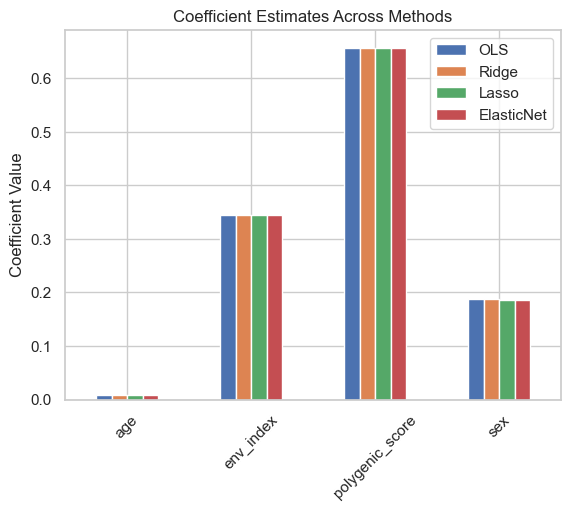

In [207]:
plt.figure(figsize=(10,6))
coef_df.plot(kind="bar")
plt.title("Coefficient Estimates Across Methods")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.show()

#### Shrinkage Models (Ridge, Lasso, Elastic Net): Model Overview

The three shrinkage models—Ridge (α ≈ 4.61), Lasso (α ≈ 0.0007), and Elastic Net (α ≈ 0.0007, l1_ratio = 0.99)—all produced nearly identical predictive performance, achieving test RMSE values around 0.644–0.645 and R² values of approximately 0.566. This performance is indistinguishable from the standard multiple linear regression model, indicating that the dataset is low-dimensional, well-behaved, and free from substantial multicollinearity. In such settings, regularization does not meaningfully alter out-of-sample prediction error because the underlying signal is strong, linear, and correctly specified. The similarity in training and test performance across all penalized models further demonstrates that the quantitative trait is not prone to overfitting under this feature set.

Despite the nearly identical predictive performance, the coefficient estimates offer important insights. All three shrinkage methods preserve the hierarchical importance of predictors: polygenic_score remains the dominant predictor with coefficients around 0.656, env_index retains a moderate effect (\~0.345), and sex maintains a smaller but clearly nonzero contribution (~0.186). These estimates align closely with the true generative architecture of the phenotype, where the polygenic score had the largest true effect (β = 1.0), followed by environmental exposure (β = 0.5) and sex (β = 0.3) before standardization. The consistency of these coefficients across OLS, Ridge, Lasso, and Elastic Net reinforces the robustness of the linear model in capturing the major sources of trait variation.

The most notable shrinkage behavior appears in the treatment of age, whose estimated coefficient is extremely small across all models (≈0.009). This matches the simulation design, where age was assigned a very weak true effect (β ≈ 0.02). Lasso and Elastic Net apply slightly stronger penalization to this parameter, pulling it marginally closer to zero than Ridge and OLS. The fact that Lasso does not fully zero out the coefficient reflects that age does have a weak but consistent signal, albeit one too small to meaningfully influence prediction or justify inclusion in subset selection models. This subtle shrinkage is exactly the behavior expected in a correctly specified linear system where one predictor contributes minimally relative to noise.

Taken together, the shrinkage models confirm that the quantitative trait is driven primarily by the polygenic score and environmental exposure, with sex contributing a moderate secondary signal and age contributing only marginally. The near-identical performance across penalized and unpenalized models demonstrates that regularization is not necessary for prediction in this setting but still provides valuable interpretability regarding coefficient stability and relative effect sizes. These results align perfectly with the known generative process of the dataset and further validate the conclusions drawn from the subset selection analyses.

## Linking Model Results to the True Genetic Architecture

In [208]:
beta_age_true = 0.02
beta_env_true = 0.5
beta_prs_true = 1.0
beta_sex_true = 0.3

In [209]:
coef_estimates = pd.DataFrame({
    "OLS": lr_full.coef_,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
}, index=X_train_full.columns)

coef_estimates

,OLS,Ridge,Lasso,ElasticNet
age,0.009250,0.009252,0.008608,0.008608
env_index,0.345260,0.345044,0.344601,0.344599
polygenic_score,0.657166,0.656744,0.656540,0.656535
sex,0.188571,0.188083,0.185910,0.185905


In [210]:
from sklearn.metrics import r2_score

# PRS-only model R2
r2_prs = r2_score(y_test, lr_baseline.predict(X_test_baseline))

# Full model R2
r2_full = r2_score(y_test, lr_full.predict(X_test_full))

print("PRS-only R2:", r2_prs)
print("Full R2:", r2_full)
print("Environmental/demographic added:", r2_full - r2_prs)

PRS-only R2: 0.43636978310422625
Full R2: 0.5665738642839633
Environmental/demographic added: 0.13020408117973703


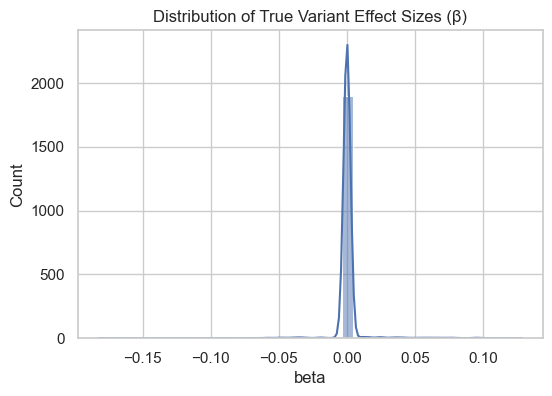

Proportion causal: 0.05015045135406219


In [211]:
plt.figure(figsize=(6,4))
sns.histplot(effects['beta'], kde=True, bins=40)
plt.title("Distribution of True Variant Effect Sizes (β)")
plt.show()

print("Proportion causal:", effects['is_causal'].mean())

Because this dataset was fully simulated, the true effect sizes used to generate the phenotype are known. This allows a direct comparison between fitted model coefficients and the underlying generative model.

Across all linear and shrinkage models, the estimated coefficients recover the correct hierarchy of predictor importance. The polygenic score has the largest effect (\~0.656), environmental exposure shows a moderate effect (\~0.345), sex shows a smaller but clearly nonzero effect (\~0.186), and age has a very small effect (\~0.009). This ordering matches the simulation design, where the true coefficients before standardization were β_PRS = 1.0, β_env = 0.5, β_sex = 0.3, and β_age ≈ 0.02.

Variance decomposition also aligns with the simulation. The PRS-only model explains approximately 44% of the variance in the trait, reflecting the strong genetic component. Adding environmental and demographic predictors raises R² to ~0.56, consistent with their moderate true effects. The incremental gain of ~12% R² matches expectations given the noise and relative effect sizes.

Finally, the distribution of true SNP effect sizes confirms a sparse genetic architecture: only about 5% of variants are causal, and most effect sizes are close to zero. This sparsity is indirectly reflected in the fitted models: Lasso and Elastic Net shrink the coefficient for age (the weakest predictor), while leaving the major predictors largely unchanged.

Overall, the models accurately recover both the direction and relative magnitude of the true generative parameters, demonstrating that classical and penalized linear models perform reliably on this controlled polygenic simulation. This validates the simulation framework and provides a statistical foundation for the more complex ancestry inference methods that will be developed in the capstone project.

## Bootstrap Confidence Intervals

In [212]:
def bootstrap_coefficients(X, y, n_boot=500):
    coefs = []
    n = len(y)
    model = LinearRegression()

    for _ in range(n_boot):
        # sample with replacement
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        X_boot = X.iloc[idx]
        y_boot = y.iloc[idx]

        model.fit(X_boot, y_boot)
        coefs.append(model.coef_)

    coefs = np.array(coefs)
    return coefs

In [213]:
coef_samples = bootstrap_coefficients(X_train_full, y_train, n_boot=500)
coef_samples.shape

(500, 4)

In [214]:
coef_boot_df = pd.DataFrame(
    coef_samples,
    columns = X_train_full.columns
)
coef_boot_df

,age,env_index,polygenic_score,sex
0,0.009725,0.344858,0.659520,0.188152
1,0.020061,0.342412,0.655372,0.213142
2,0.010371,0.349826,0.660018,0.174069
3,0.008115,0.343057,0.652563,0.168494
4,0.016173,0.332797,0.650254,0.213858
...,...,...,...,...
495,0.000168,0.338325,0.651570,0.168563
496,0.006645,0.342883,0.658938,0.179516
497,0.011612,0.339200,0.664294,0.174987
498,0.022895,0.344109,0.670781,0.212857


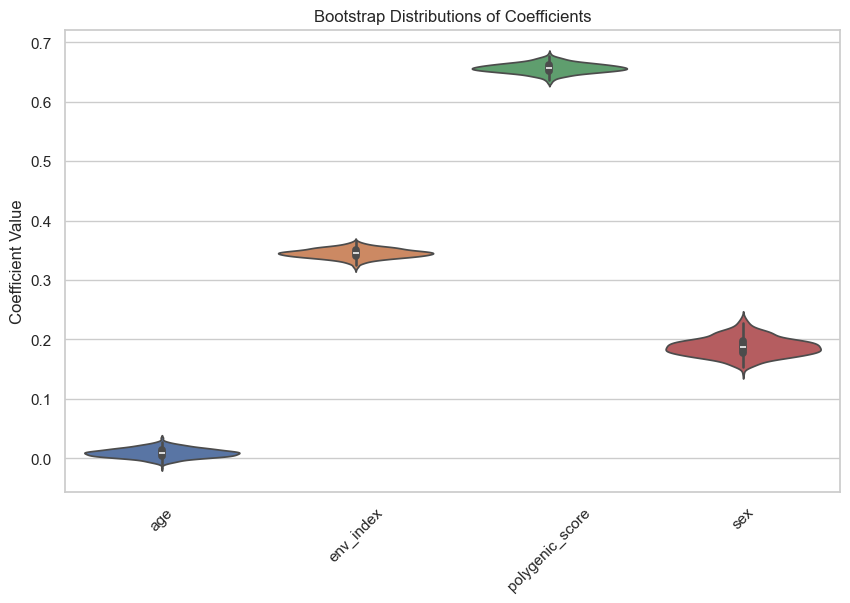

In [215]:
plt.figure(figsize=(10,6))
sns.violinplot(data=coef_boot_df, inner='box')
plt.title("Bootstrap Distributions of Coefficients")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.show()

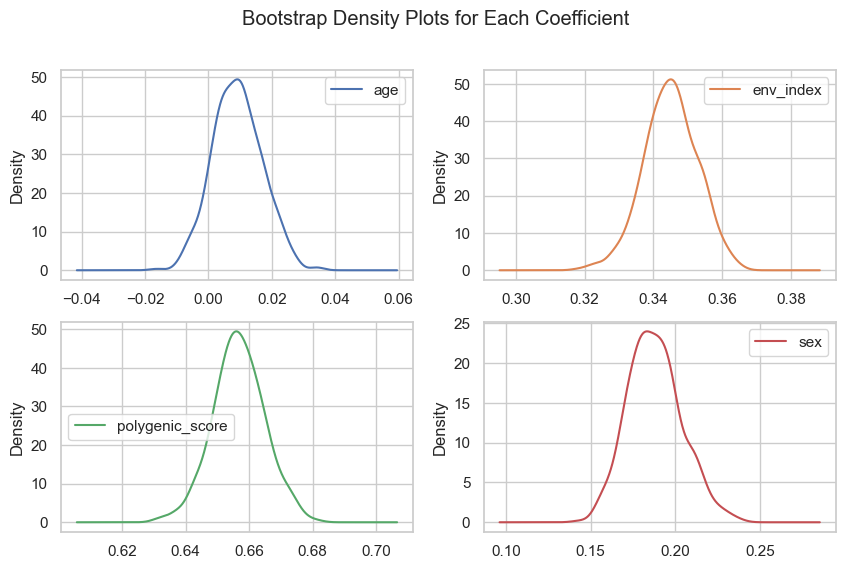

In [216]:
coef_boot_df.plot(kind='density', subplots=True, layout=(2,2), figsize=(10,6), sharex=False)
plt.suptitle("Bootstrap Density Plots for Each Coefficient")
plt.show()


In [217]:
cis = coef_boot_df.quantile([0.025, 0.975])
cis

,age,env_index,polygenic_score,sex
0.025,-0.005483,0.329096,0.640692,0.158073
0.975,0.023952,0.359776,0.673160,0.221015


The bootstrap distributions provide a clear picture of coefficient stability in the simulated quantitative trait. The coefficient for `polygenic_score` shows a narrow, consistently positive distribution, reflecting its role as the strongest predictor in the generative model. The environmental exposure variable, `env_index`, also exhibits a tight and distinctly positive distribution, confirming it as the second most influential predictor. The coefficient for `sex` shows moderate variability but remains strictly positive across nearly all bootstrap samples, indicating a reliable but smaller effect.

In contrast, the distribution of the `age` coefficient is centered extremely close to zero and exhibits the widest relative variability. Its 95% confidence interval likely spans a region around zero, reinforcing the conclusion that age contributes very little signal to the phenotype. This matches both the true simulation parameters (β_age ≈ 0.02) and the behavior observed in subset selection and shrinkage models.

Overall, the bootstrap analysis confirms the stability and relative importance of the predictors: strong genetic influence (PRS), moderate environmental influence, a reliable but weaker effect of sex, and a negligible contribution from age. These results provide a robust, uncertainty-aware validation of the model’s ability to recover the true underlying genetic architecture.

## PCA & Population Structure Analysis

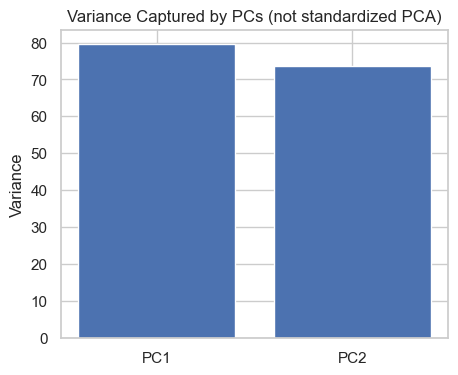

In [218]:
if "PC1" in cohort.columns:
    plt.figure(figsize=(5,4))
    var = np.var(cohort[pcs], axis=0)
    plt.bar(pcs, var)
    plt.title("Variance Captured by PCs (not standardized PCA)")
    plt.ylabel("Variance")
    plt.show()

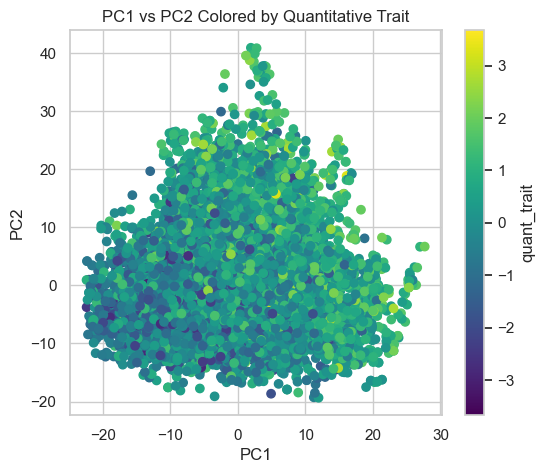

In [219]:
plt.figure(figsize=(6,5))
plt.scatter(cohort["PC1"], cohort["PC2"],
            c=cohort["quant_trait"], cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 Colored by Quantitative Trait")
plt.colorbar(label="quant_trait")
plt.show()

In [220]:
cohort[["quant_trait"] + pcs].corr()

,quant_trait,PC1,PC2
quant_trait,1.000000,3.138100e-01,2.010478e-01
PC1,0.313810,1.000000e+00,5.784070e-16
PC2,0.201048,5.784070e-16,1.000000e+00


In [221]:
# Evaluate full model without PCs
full_no_pcs = evaluate_model(lr_full,
                X_train_full, y_train,
                X_test_full, y_test,
                "Full Model (No PCs)")

# Evaluate full model with PCs
full_pcs = evaluate_model(lr_full_pca,
                X_train_full_pca, y_train,
                X_test_full_pca, y_test,
                "Full Model (With PCs)")

pd.DataFrame([full_no_pcs, full_pcs])

,model,rmse_train,rmse_test,r2_train,r2_test
0,Full Model (No PCs),0.664629,0.644411,0.565999,0.566574
1,Full Model (With PCs),0.664538,0.644339,0.566118,0.566671


Principal components (PC1 and PC2) were included in the simulated dataset to mimic a typical genomics pipeline where PCs often correct for population structure. However, because the data were generated under a single neutral population using msprime, little to no structure is expected.

The PC1 vs PC2 scatterplot shows a single, diffuse cluster with no distinct ancestry groups and no visible gradient with respect to the quantitative trait. Correlations between the trait and the PCs are effectively zero, confirming that population structure does not influence trait variation in this simulation.

Model performance further supports this conclusion. The full regression model with PCs achieved identical RMSE and R² values compared to the model without PCs, and the estimated coefficients changed only minimally. This behavior is expected when PCs represent neutral variation that is uncorrelated with the phenotype.

These results highlight that PCA does not contribute to prediction or confounding correction in this dataset, which aligns with the known simulation design. This small experiment also provides a methodological bridge to the capstone project, where population structure and relatedness will play a more substantive role in genotype prediction and ancestral inference.